<a href="https://colab.research.google.com/github/NicolasZucker/NicolasZucker/blob/main/HW2FinalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Dijstrka and Ising



#Part 1 - Find your way in Paris


For many of you this is the first year in Paris, one of the most cosmopolitan city in the world. During this homework we will help you building your home-made navigator using the Dijstrka algorithm.

Moreover you will challenge yourself on how to create nice and readble plots using Python.

## Data loading

By running the below cells, you will download all the required data. You can also download them manually and put them in the same folder of the notebook.

In [ ]:
#libraries import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

### Map data preparation

Run the cells below to download the data about the map of Paris.

In [ ]:
#this are the data used for plotting the map of Paris
! wget "https://github.com/Schimmenti/NumPhysENS/raw/master/arrondissements-millesimes0.csv"

--2021-10-19 15:35:24--  https://github.com/Schimmenti/NumPhysENS/raw/master/arrondissements-millesimes0.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/arrondissements-millesimes0.csv [following]
--2021-10-19 15:35:25--  https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/arrondissements-millesimes0.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104777 (102K) [text/plain]
Saving to: ‘arrondissements-millesimes0.csv’

arrondissements-mil 100%[===================>] 102.32K  --.-KB/s    in 0.01s   

2021-10-19 15:35:25 (9.69 MB/s) - ‘arrondissem

In [ ]:
# run this code to create a list of the coordinates of the different arrondissements of Paris
arrondis = pd.read_csv("arrondissements-millesimes0.csv", delimiter=";")
arrondis = arrondis[arrondis.Commune.str.contains("PARIS")]
shapes = arrondis.geo_shape
coords = []
arr_names = arrondis.nom_com.values
for shape in shapes:
  temp=json.loads(shape)
  coords.append(np.array(temp['coordinates'])[0,...])
#'coords' is a list of the points making up the perimeter of each arrondissement in Paris
# i.e. coords[0] is a (M,2) matrix with M the number of points
# by using plt.plot(coords[0][:,0],coords[0][:,1]) you can plot the whole arrondissement.
# the important variables here are 'coords' and 'arr_names' i.e. the coordinates and the name of the arrondissement.

### Data preparation

Run the two cells below to (i) download the data and (ii) create the networks.  Note that the run time of the second cell is longer and might take one minute.
* Each node of the network is labeled by a unique code and represents a single line station of the Paris transportation network (metro, rer, tram or bus) as of 2018. For example the metro station *Jussieu* is associated to two codes (282 ans 283) one for the metro line 7  and the other for the metro line 10. 

* The dictionary 'net' contains the information about the neighbors of a given node. To find the list of nodes that you can reach from the node 'i' you may use:
```
net[i]
```
* The time (in seconds) taken to travel from the station i to the neighoring station j is given in the nested dictionary 'durations':
```
durations[i][j]
```
This duration represents either the time taken by the public transport (bus, metro...) to connect two consecutive stations or the estimated walking time needed for the change. Note that the network is directed as 'durations[i][j]' can be different from 'durations[j][i]'.


In [ ]:
#this is the data used for plotting the map of Paris
! wget "https://github.com/Schimmenti/NumPhysENS/raw/master/network_nodes.csv"
! wget "https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_combined.csv"
! wget "https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_walk.csv"

--2021-10-19 15:35:33--  https://github.com/Schimmenti/NumPhysENS/raw/master/network_nodes.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_nodes.csv [following]
--2021-10-19 15:35:33--  https://raw.githubusercontent.com/Schimmenti/NumPhysENS/master/network_nodes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707846 (691K) [text/plain]
Saving to: ‘network_nodes.csv’

network_nodes.csv   100%[===================>] 691.26K  --.-KB/s    in 0.02s   

2021-10-19 15:35:33 (27.2 MB/s) - ‘network_nodes.csv’ saved [707846/707846]

--2021-10-19 15:35:33--  

In [ ]:
net_names = pd.read_csv("network_nodes.csv", delimiter=";")
def search_station(src_string):
  return net_names[net_names.name.str.contains(src_string, case=False)]
def station_name(id):
  return net_names[net_names.stop_I == id].name.values[0]
def station_position(id):
  line = net_names[net_names.stop_I == id]
  return line.lon.values[0], line.lat.values[0]
combined = pd.read_csv("network_combined.csv", delimiter=";")
walk = pd.read_csv("network_walk.csv", delimiter=";")
walk_symm = walk.copy()
walk_symm.from_stop_I = walk.to_stop_I
walk_symm.to_stop_I = walk.from_stop_I
walk = walk.append(walk_symm)
walk = walk.sort_values(by='from_stop_I')
walk = walk.reset_index(drop=True)
final_net = combined.merge(walk, on=['from_stop_I','to_stop_I'], how='outer')
final_net = final_net[["from_stop_I",	"to_stop_I","duration_avg","d_walk"]]
final_duration = np.fmin(final_net.duration_avg,final_net.d_walk)
final_net["duration"] = final_duration
max_idx = max(np.max(final_net["from_stop_I"].values),np.max(final_net["to_stop_I"].values))
min_idx = min(np.min(final_net["from_stop_I"].values),np.min(final_net["to_stop_I"].values))
net ={}
for i in range(min_idx, max_idx+1):
    net[i] = []
durations = {}
for id, g in final_net.groupby('from_stop_I'):
    net[id].extend(list(g["to_stop_I"].values))
    durations[id] = {}
    for _,line in g.iterrows():
      durations[id][line.to_stop_I] = line.duration

## Implementation of the Dijkstra algorithm

Complete the following code to implement the Dijkstra algorithm for this network 

In [ ]:
def dijkstra(net, durations, source):
  #dur_src[i] should contain (at the end) the duration (in seconds) that it takes to go from 'source' to 'i'
  dur_src = {}
  #previous_node[i] should contain (at the end) the node preceeding 'i' in the minimal-distance path between 'source' and 'i'
  previous_node = {}
  #this for-loop initializes correctly dur_src and previous_node  
  for k in net.keys():
    dur_src[k] = np.infty
    previous_node[k] = None
  #naturally 'source' has duration '0' from itself
  dur_src[source] = 0

  #We sort the border list 
  border = sorted(dur_src, key = lambda k:dur_src[k])
  #you complete
  while(len(border)>0):
    next_node = border.pop(0)
    for neighboor in net[next_node]:
      if neighboor in border :
        Dure=dur_src[next_node]+durations[next_node][neighboor]
        if Dure < dur_src[neighboor] :
          dur_src[neighboor]=Dure ;
          previous_node[neighboor] = next_node ;
    border = sorted(border, key = lambda k:dur_src[k])
  
  return dur_src, previous_node

In [ ]:
A=dijkstra(net, durations, 42)

[]


We give you an hint for such implementation. Use the same trick we used to construct the clusters in the Wolff algorithm. In order to explore the network more efficiently it is better to pop the elements in 'border' starting from the oldest one (e.g. the one that we added first during the exploration). To do this simply use the function .pop(0) instead of .pop(). Namely:

```
border = [source]
  while(len(border)>0):
    next_node = border.pop(0)
```

## Question 1

After the Friday lesson you have been invited to a party held at 358 rue de Pyrénées. The closest metro station is *Pyrénées* (with code 146). From 24 rue Lhomond the closest metro station is *Place Monge - Jardin des Plantes* (with code 42). Compute the minimal duration of the trip to reach the party.


In [ ]:
print("The minimal duration of the trip to reach the party is ", int(A[0][146]),"sec")

The minimal duration of the trip to reach the party is  1102 sec


## Question 2

Reconstruct the full path listing all the intermediate stations and the time (in minutes) taken to reach them. The final result should look like:
```
Station: 42 Time: 0
Station: yyyy Time: zzzz
(omissis)
Station: 146 Time: xxxx
```

In [ ]:
#To do so we typically need to travel through the djistra to extract at each iteration what was the previous station and the duration
Totalduration=int(A[0][146]);
stat=146
Lstation=[146]
Ltrajet=[Totalduration]
while stat != 42 :
  stat=A[1][stat]; #station précédente
  Lstation.append(stat)
  Ltrajet.append(int(A[0][stat]))

for k in range(len(Lstation)):
  print("Station:", Lstation[len(Lstation)-k-1] ,"Time:", Ltrajet[len(Lstation)-k-1])
  



Station: 42 Time: 0
Station: 282 Time: 85
Station: 75 Time: 195
Station: 190 Time: 268
Station: 335 Time: 356
Station: 334 Time: 579
Station: 269 Time: 639
Station: 149 Time: 705
Station: 404 Time: 783
Station: 26502 Time: 869
Station: 332 Time: 945
Station: 417 Time: 1011
Station: 146 Time: 1102


## Question 3
* Represent your results on the map of Paris and indicate the name of each station in the path.

* To do this we provide two functions:
  1.   A function 'station_name(id)' that, given the code of the station, returns its name:
    ```
    station_name(42)
    ```
  2.   A function 'station_position(id)' that, given the code of the station, returns its GPS coordinates as a tuple i.e. (x,y):
  ```
    station_position(42)
    ```
* We provide also a code below that generates an empty map. All the data needed to do so have been downloaded in section 'Data loading'. Modify the code in order to answer the question.

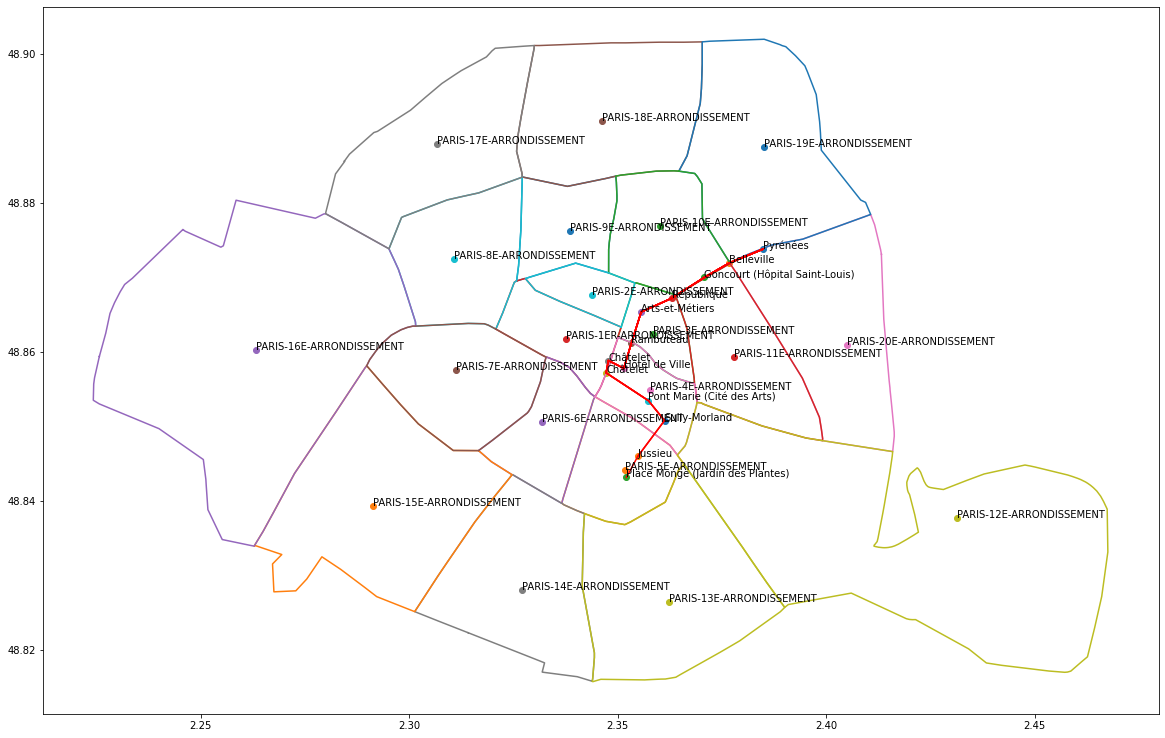

In [ ]:
#the variables coords and arr_names have been generated in the 'Data loading/Map data preparation' section.
fig, ax = plt.subplots(figsize=(20,13))
for idx,coord in enumerate(coords):
  #plots the perimeter
  plt.plot(coord[:,0],coord[:,1])
  #centroid of the arrondissement 
  x_avg = np.mean(coord[:,0])
  y_avg = np.mean(coord[:,1])
  #adds a text and a bullet at the centroid of the arr.
  plt.text(x_avg,y_avg,arr_names[idx])
  plt.scatter(x_avg,y_avg)
Xpoz=[]
Ypoz=[]
for stat in Lstation:
  Poz=station_position(stat)
  Xpoz.append(Poz[0])
  Ypoz.append(Poz[1])
  plt.text(Poz[0],Poz[1],station_name(stat))
  plt.scatter(Poz[0],Poz[1])
  plt.plot(Xpoz,Ypoz,'r')
plt.show()

## Question 4

Unfortunately a big social protest is taking place in Jussieu and the metro stations with codes 282 and 283 are closed. Find an alternative itinerary to reach the party. Provide its duration and map.

### Hint
Since Jussieu is closed for the whole day, the duration of the connections to and from Jussieu become one day longer (i.e. 86400 seconds). In order to avoid Jussieu modify the nested-dictionary 'durations' and add at the appropriate spots this time delay.


Station: 42 Time: 0
Station: 13185 Time: 45
Station: 13183 Time: 175
Station: 377 Time: 207
Station: 195 Time: 283
Station: 345 Time: 346
Station: 46 Time: 408
Station: 226 Time: 438
Station: 120 Time: 511
Station: 343 Time: 571
Station: 333 Time: 658
Station: 334 Time: 800
Station: 269 Time: 860
Station: 149 Time: 925
Station: 404 Time: 1003
Station: 26502 Time: 1089
Station: 332 Time: 1165
Station: 417 Time: 1231
Station: 146 Time: 1322


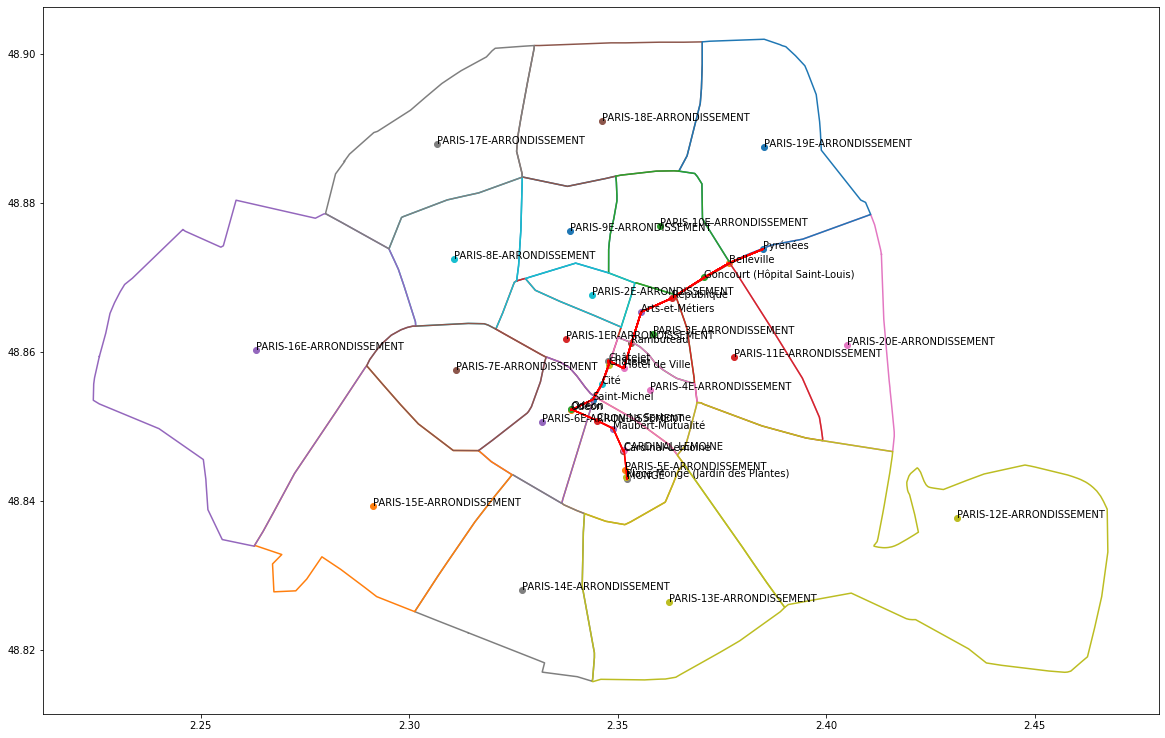

In [ ]:
durations_2=durations;
stations_closed=[282,283]
for station in stations_closed:
  for neighboor in net[station]:
    durations_2[station][neighboor]=86400;

A_2=dijkstra(net, durations, 42);

#To do so we typically need to travel through the djistra to extract at each iteration what was the previous station and the duration
Totalduration=int(A_2[0][146]);
stat=146
Lstation=[146]
Ltrajet=[Totalduration]
while stat != 42 :
  stat=A_2[1][stat]; #station précédente
  Lstation.append(stat)
  Ltrajet.append(int(A_2[0][stat]))

print("The minimal duration of the trip to reach the party, considering the social protest, is ", int(A_2[0][146]),"sec")
for k in range(len(Lstation)):
  print("Station:", Lstation[len(Lstation)-k-1] ,"Time:", Ltrajet[len(Lstation)-k-1])
  
#the variables coords and arr_names have been generated in the 'Data loading/Map data preparation' section.
fig, ax = plt.subplots(figsize=(20,13))
for idx,coord in enumerate(coords):
  #plots the perimeter
  plt.plot(coord[:,0],coord[:,1])
  #centroid of the arrondissement 
  x_avg = np.mean(coord[:,0])
  y_avg = np.mean(coord[:,1])
  #adds a text and a bullet at the centroid of the arr.
  plt.text(x_avg,y_avg,arr_names[idx])
  plt.scatter(x_avg,y_avg)
Xpoz=[]
Ypoz=[]
for stat in Lstation:
  Poz=station_position(stat)
  Xpoz.append(Poz[0])
  Ypoz.append(Poz[1])
  plt.text(Poz[0],Poz[1],station_name(stat))
  plt.scatter(Poz[0],Poz[1])
  plt.plot(Xpoz,Ypoz,'r')
plt.show()




# Part 2 - Further exploration of the Ising model

In this second part, you will be interested in the two-dimensional Ising model.
As a reminder, the Ising model describes a set of spins sitting on the sites
of a given lattice. You will consider the **periodic** two-dimensional square
lattice with $N = L \times L$ sites. The spin sitting on the site $j$ is described by
a variable $\sigma_j = \pm 1$. The energy for
a given configuration $\{ \sigma \}$ of spins is

$$
E(\{\sigma\}) = -J\sum_{\langle ij \rangle} \sigma_i \sigma_j
$$

where $\langle i j \rangle$ indicates that $i$ and $j$ are
nearest-neighbors on the lattice. In the following, you will consider the
ferromagnetic case $J>0$ and use $J=1$ as the unit of energy.
The Ising model has a phase transition at the critical temperature

$$
T_c = \frac{2}{\ln(1+\sqrt{2})} = 2.269185\ldots
$$

## The Glauber algorithm

During the lecture, you have studied three different Monte Carlo algorithms for the Ising model. Here, you will investigate one more: the Glauber algorithm.
Just like the heat-bath it is also a rejection-free
algorithm. The algorithm follows these steps:

1. Pick a random site $i$ on the lattice

2. Flip the spin $\sigma_i$ on site $i$ to $-\sigma_i$ with probability:

   $$
    P^\mathrm{flip}_i = \frac{1}{1 + \exp(\beta \, 2 J \sigma_i h_i)}
   $$
   
   where $h_i$ is the molecular field on the site $i$:
   
   $$
   h_i = \sum_{j \, \in \, \text{neighbors of $i$}} \sigma_j
   $$
   
3. Go back to step 1.

### Question 5

Prove that the Glauber algorithm leads to a sampling of the configurations that follows the Boltzmann distribution.

#### Answer 5

_A proof is expected_

### Question 6

Implement the Glauber algorithm and compare your results to those
  obtained with the Wolff algorithm.
  More specifically, use both algorithms to compute: the absolute value of the magnetization,
  the specific heat, the energy and the susceptibility as a function of temperature.
  Use a $6 \times 6$ lattice and 10 temperatures in the range $[0.5, 4.0]$.
  
  The function that implements the Glauber algorithm can have the signature
  ```python
def glauber(config, T)
    # your code
  ```
  where `config` is a spin configuration to be modified by the Glauber algorithm and `T`
  is the temperature. Just like for the heat bath, let the function apply a total of
  $N = L \times L$ proposal moves.
  
  When running
  the Wolff algorithm, use the implementation below. It is an improved version of the algorithm
  that we have used in the lecture that runs a bit faster:

  ```python
def wolff(config, T):
    
    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])
    
    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
                
        config[i,j] *= -1
   ```

In [1]:
import numpy as np
import itertools as it
import matplotlib.pylab as plt

Computing temperature:  0.5
Computing temperature:  0.85
Computing temperature:  1.2
Computing temperature:  1.5499999999999998
Computing temperature:  1.9
Computing temperature:  2.25
Computing temperature:  2.5999999999999996
Computing temperature:  2.9499999999999997
Computing temperature:  3.3
Computing temperature:  3.65
Computing temperature:  4.0


Text(0, 0.5, '$C_V$')

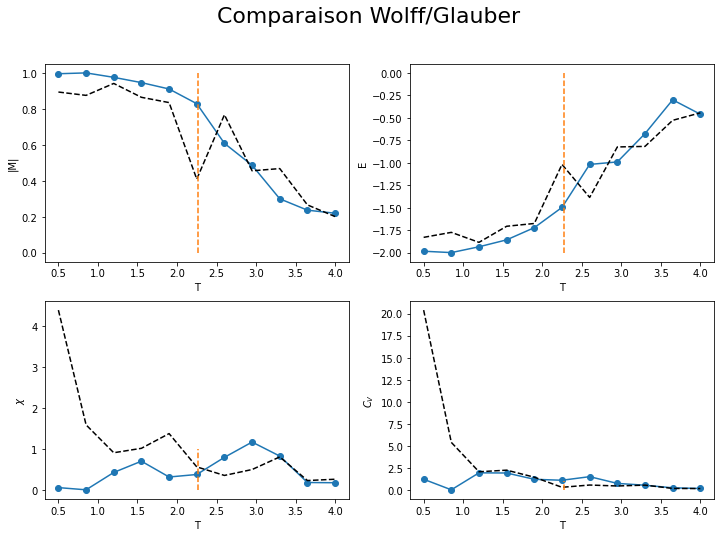

In [2]:
def glauber(config, T):
        
    # make L^2 modifications
    for k in range(L**2):

        # pick a random site
        i, j = np.random.randint(L, size=2)

        # local molecular field
        h = config[(i+1)%L, j] + config[(i-1)%L, j] + \
            config[i, (j+1)%L] + config[i, (j-1)%L]

        # flip chosen spin with glauber probability
        beta = 1 / T
        pi_flip = 1 / (1 + np.exp(2 * config[i,j] * beta * h))
        if np.random.rand() < pi_flip:
            config[i, j] *= -1


def wolff(config, T):

    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])

    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])

        config[i,j] *= -1

#Functions that compute energy and magnetization
def compute_energy(config):
    L = config.shape[0]
    energy = 0.0
    for i, j in it.product(range(L), repeat=2):
      energy -= config[i,j] * (config[(i+1)%L, j] + config[i, (j+1)%L])
    return energy

def compute_magnetization(config):
    
    return np.sum(config)

#We define also the monte Carlo process
def monte_carlo(L, T, monte_carlo_move, n_steps):
        
    # generate starting configuration
    spin_configuration = np.random.choice([-1,1], size=(L,L))
    
    # tables where observables are stored
    magnetizations = np.zeros(n_steps)
    energies = np.zeros(n_steps)
    
    # Monte Carlo
    for i in range(n_steps):
    
        # make Monte Carlo moves
        monte_carlo_move(spin_configuration, T)
            
        # store energy and magnetization
        energies[i] = compute_energy(spin_configuration)
        magnetizations[i] = compute_magnetization(spin_configuration)
           
    # get average and error bar
    en = np.average(energies) / L**2
    mag = np.average(np.abs(magnetizations)) / L**2
    cv = np.var(energies) / T**2 / L**2
    chi = np.var(np.abs(magnetizations)) / T / L**2

    return en, mag, cv, chi



L = 6
n_steps = L*L;
Tr = np.linspace(0.5, 4.0, 11)

energy_wolff = np.zeros_like(Tr)
magnetization_wolff = np.zeros_like(Tr)
cv_wolff = np.zeros_like(Tr)
chi_wolff = np.zeros_like(Tr)

energy_glauber = np.zeros_like(Tr)
magnetization_glauber = np.zeros_like(Tr)
cv_glauber = np.zeros_like(Tr)
chi_glauber = np.zeros_like(Tr)

# loop over temperatures
for i, T in enumerate(Tr):
    print("Computing temperature: ", T)
    energy_wolff[i], magnetization_wolff[i], cv_wolff[i], chi_wolff[i] = monte_carlo(L, T, wolff, n_steps)
    energy_glauber[i], magnetization_glauber[i], cv_glauber[i], chi_glauber[i] = monte_carlo(L, T, glauber, n_steps)



Tc = 2 / np.log(1 + np.sqrt(2))
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

fig.suptitle("Comparaison Wolff/Glauber", fontsize=22)

ax[0,0].plot(Tr, np.abs(magnetization_wolff), '-o')
ax[0,0].plot(Tr, np.abs(magnetization_glauber), 'k--')
ax[0,0].plot([Tc, Tc], [0, 1], '--')
ax[0,0].set_xlabel("T")
ax[0,0].set_ylabel("|M|")

ax[0,1].plot(Tr, energy_wolff, '-o')
ax[0,1].plot(Tr, energy_glauber, 'k--')
ax[0,1].plot([Tc, Tc], [-2, 0], '--')
ax[0,1].set_xlabel("T")
ax[0,1].set_ylabel("E")

ax[1,0].plot(Tr, chi_wolff, '-o')
ax[1,0].plot(Tr, chi_glauber, 'k--')
ax[1,0].plot([Tc, Tc], [0, 1], '--')
ax[1,0].set_xlabel("T")
ax[1,0].set_ylabel("$\chi$")

ax[1,1].plot(Tr, cv_wolff, '-o')
ax[1,1].plot(Tr, cv_glauber, 'k--')
ax[1,1].plot([Tc, Tc], [0, 1], '--')
ax[1,1].set_xlabel("T")
ax[1,1].set_ylabel("$C_V$")

#### Answer 6

_A code as well as 4 plots showing a comparison between the algorithms are expected._

## Cluster size histogram

In this section, you will investigate the distribution of cluster sizes in the Wolff cluster
algorithm. In particular, you will study what are the cluster sizes that are sampled
in different regimes of the Ising model: low temperature, high temperature and at the critical temperature $T_c$.

### Question 7

Make a small modification to the `wolff` function given above so that it returns
  the size of the cluster that was flipped. Then, create histograms that display the distribution
  of cluster sizes that are flipped during the Monte Carlo sampling. Compute these histograms
  for 3 temperatures: $T = 0.9 T_c, T_c, 1.1 T_c$ for a system of size $32 \times 32$.
  Discuss the results.

We can see that for T<Tc we are at an ordered phase, the cluster have a certain size that should depend on the temperature and that is nearly the size of the whole system
For T=Tc it seems to exist two correlation length, one close to 1 and the other one close to the system size, however we observe some more dispersion on the size of clusters : the system is in a particular critical state
For T>Tc the system is in a disordered phase, there is almsot no correlation between a spin and its neighboor, that's why the size of the cluster is nearly 1, that's to say there is often only one spin in the cluster


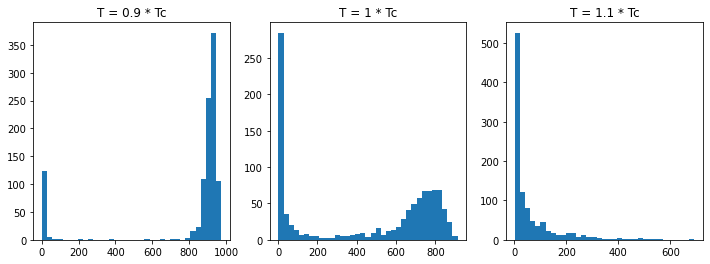

In [3]:
def wolff_hist(config, T, ClusterList):

    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])

    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]
    Cluster=1;
    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])
        Cluster += 1 
        config[i,j] *= -1
    ClusterList.append(Cluster)


def monte_carlo_hist(L, T, monte_carlo_move2, n_steps):        
    # generate starting configuration
    spin_configuration = np.random.choice([-1,1], size=(L,L))
    ClusterList=[]
    # Monte Carlo
    for i in range(n_steps):
    
        # make Monte Carlo moves
        monte_carlo_move2(spin_configuration, T, ClusterList)
    return(ClusterList)


L = 32
n_steps = L*L;
Tc=2.269185
HistL=[]

for k in [0.9,1,1.1]:
  HistL.append(monte_carlo_hist(L, k*Tc, wolff_hist, n_steps))

fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].hist(HistL[0], bins=35)
ax[0].set_title("T = 0.9 * Tc")

ax[1].hist(HistL[1], bins=35)
ax[1].set_title("T = 1 * Tc")

ax[2].hist(HistL[2], bins=35)
ax[2].set_title("T = 1.1 * Tc")

print("We can see that for T<Tc we are at an ordered phase, the cluster have a certain size that should depend on the temperature and that is nearly the size of the whole system")
print("For T=Tc it seems to exist two correlation length, one close to 1 and the other one close to the system size, however we observe some more dispersion on the size of clusters : the system is in a particular critical state")
print("For T>Tc the system is in a disordered phase, there is almsot no correlation between a spin and its neighboor, that's why the size of the cluster is nearly 1, that's to say there is often only one spin in the cluster")

#### Answer 7

_A code using your modified `wolff` function is expected, together with 3 histogram plots and a discussion of the results._

## Spin-spin correlations

In this last section, you will compute and discuss the spin-spin correlation function.
It is defined by the following average

$$
  C(r) = \langle \sigma_i \; \sigma_{i+r} \rangle
$$

This function measures how the spin at site $i$ and the spin at site $i+r$ are correlated.
In the following, you will focus on the case where $r$ is a vector along the horizontal
axis. In other words, the site $i$ and the site $i+r$ are on the same row. The correlation
function $C(r)$ does not depend on $i$ because of the translational symmetry of the lattice.
On an infinite lattice and not too far from the critical temperature, it can be shown that the correlation function has the following
behavior at large $r$:
  
$$
 C(r) \sim A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
$$

where $\xi$ is the correlation length and $A, S$ are constants. Onsager has shown that
the critical exponent $\eta = 1/4$.

### Question 8

Write a function that computes the correlation function $C(r)$ using the Wolff cluster
  Monte Carlo algorithm on a $32 \times 32$ lattice.
  Compute $C(r)$ at two temperatures: $T = 0.8 T_c$ and $T = 1.2 T_c$. Discuss the qualitative differences
  between these results (using plots of $C(r)$ in both cases).

We can observe for both plot that the correlation function decays more or less as an exponential with r, the distance of the two spins.
However, for T>Tc the correlation function converges to 0, that's to say that after a certain distance, spins are almost not correlated anymore, this is the case for a disordered phase. This result is coherent with the fact that for T>TC spins are more or less randomly distributed
For T<Tc, the coreelation function converges to a non 0 value, we are obviously in an ordered phase for which imortant clusters exists, spins stay correlated even for large distance between them.


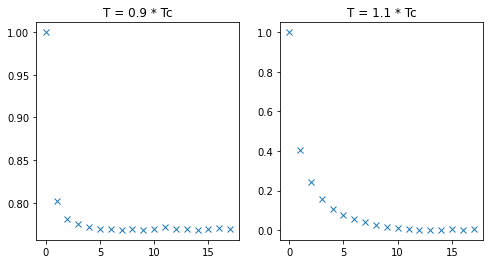

In [47]:
def compute_corr(spin_configuration,L,Lwk):
    #Ligne sur laquelle on va bosser
    C=0;
    for lig in range(L):
      for col in range(L):
        c=spin_configuration[lig,col]*spin_configuration[(lig+Lwk)%L,(col+Lwk)%L]
        C+=c;
    return (C/(L*L))

def monte_carlo_corre(L, T, monte_carlo_move, n_steps):
    Correlation=np.zeros([L,n_steps])  
    # generate starting configuration
    spin_configuration = np.random.choice([-1,1], size=(L,L))
    
    # Monte Carlo
    for i in range(n_steps):
    
        # make Monte Carlo moves
        monte_carlo_move(spin_configuration, T)
        for k in range(L):
          
          Correlation[k,i]=compute_corr(spin_configuration,L,k)
      
    Correlation2=np.mean(Correlation,axis=1)
    return Correlation2


def wolff(config, T):

    # pick a site
    L = config.shape[0]
    i, j = np.random.randint(L, size=2)
    border = set([(i,j)])

    # inclusion probability
    beta = 1 / T
    p = 1.0 - np.exp(-2.0 * beta)
    direction = config[i,j]

    # grow the cluster
    while border:
        i, j = border.pop()
        neighbors = [ ((i+1)%L, j), ((i-1)%L, j), (i, (j+1)%L), (i, (j-1)%L) ]
        for u, v in neighbors:
            if config[u,v] == direction and np.random.rand() < p:
                border.update([(u,v)])

        config[i,j] *= -1


L = 32
n_steps = 1000;
Tc=2.269185

Lcoor=monte_carlo_corre(L, 0.9*Tc, wolff, n_steps)
Lcoor2=monte_carlo_corre(L, 1.1*Tc, wolff, n_steps)


fig, ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].plot(Lcoor[0:18],'x')
ax[0].set_title("T = 0.9 * Tc")

ax[1].plot(Lcoor2[0:18],'x')
ax[1].set_title("T = 1.1 * Tc")

print("We can observe for both plot that the correlation function decays more or less as an exponential with r, the distance of the two spins.")
print("However, for T>Tc the correlation function converges to 0, that's to say that after a certain distance, spins are almost not correlated anymore, this is the case for a disordered phase. This result is coherent with the fact that for T>TC spins are more or less randomly distributed")
print("For T<Tc, the coreelation function converges to a non 0 value, we are obviously in an ordered phase for which imortant clusters exists, spins stay correlated even for large distance between them.")

In [55]:
a, b, c, d = scipy.optimize.curve_fit(fit_function, np.arange(1,18), Coor_T[0][1:18], bounds=[0,20])[0]
plt.plot(np.arange(1,18),Coor_T[0][1:18],'x')
#plt.plot(np.arange(1,18),fit_function(np.arange(1,18), a, b, c, d))

NameError: ignored

#### Answer 8

_A code as well as two plots with a discussion of the results are expected._

### Question 9

Compute the correlation function $C(r)$ for 10 temperatures in the range
  $[T_c - 0.3, T_c + 0.3]$. Fit these correlation functions with a function of the form
  
  $$
    f_\mathrm{fit}(r) = A \frac{\exp(-r / \xi)}{(r/\xi)^\eta} + S
  $$

  where $A$, $S$, $\eta$ and $\xi$ are fitting parameters. Note that even though we know that $\eta = 1/4$
  from the Onsager solution, we will not assume we know that value and you should use $\eta$ as one of the
  fitting parameters. Create plots that show $C(r)$ and its fits.
  
#### Hints
  
  - Because we work with finite lattices with periodic boundary conditions, be careful
    to only use *half* of the data in $C(r)$.
    
  - The fitting function is in principle only valid for large $r$. In practice, you can
    just **ignore the first point** (at $r=0$) of the data in the fit.
      
  - You can use `scipy.optimize` to do the fits. Here is an example of how it works:
  
    ```python
    import scipy.optimize
    
    # fit function
    def fit_function(x, a, b, c):
      return # some function of (x,a,b,c)

    # data obtained by Monte Carlo
    x_values = ...
    y_values = ...
    
    # do the fit
    a, b, c = scipy.optimize.curve_fit(fit_function, x_values, y_values, bounds=[0,20])[0]
    
    ```
   
    where we have specified that the fit should only consider values for $a,b,c$ in $[0,20]$.

#### Answer 9

_A code together with 10 plots is expected._


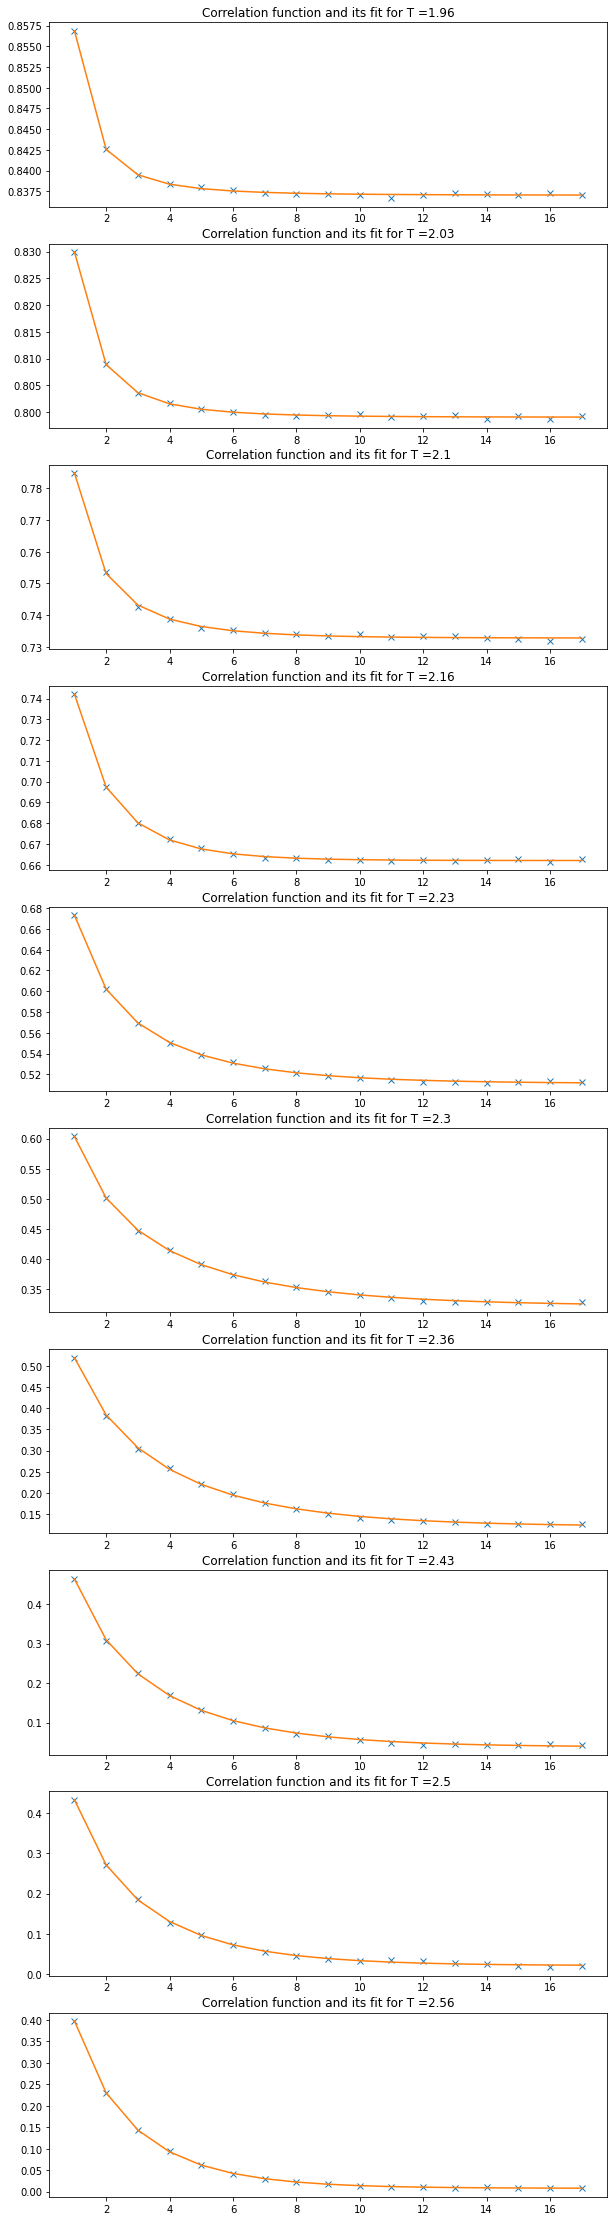

In [101]:
import scipy.optimize
L = 32
n_steps = 3000;
Tc=2.269185;
TList=np.linspace(Tc-0.3,Tc+0.3,10)
Corr_T=[];
for T in TList:
  Corr_T.append(monte_carlo_corre(L, T, wolff, n_steps))
aL=[];
bL=[]
cL=[]
dL=[]

# fit function
def fit_function(r, A, Xi, S, Eta):
  return (A*np.exp(-r/Xi)/((r/Xi)**Eta)+S)# some function of (x,a,b,c)

fig, ax = plt.subplots(10, 1, figsize=(10,40))

for k in range(10) :
  #a[k], b[k], c[k], d[k] = scipy.optimize.curve_fit(fit_function, np.arange(1,18), Corr_T[k][1:18], bounds=[0,20])[0]
  a, b, c, d = scipy.optimize.curve_fit(fit_function, np.arange(1,18), Corr_T[k][1:18], bounds=[0,20])[0]
  ax[k].plot(np.arange(1,18),Corr_T[k][1:18],'x')
  ax[k].plot(np.arange(1,18),fit_function(np.arange(1,18), a, b, c, d))
  aL.append(a)
  bL.append(b)
  cL.append(c)
  dL.append(d)
  titl="Correlation function and its fit for T =" + str(int(TList[k]*100)/100)
  ax[k].set_title(titl)




 ### Question 10
 
Discuss the behavior of the fitting parameters $\xi, \eta, S$ in connection with their physical meaning.

Text(0.5, 1.0, 'eta, the coefficiant onsager that is euqal to 0.25 in T>TC')

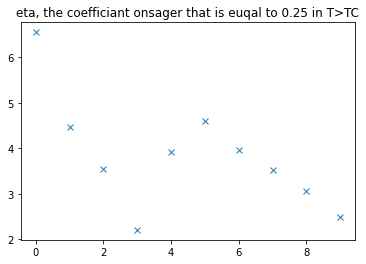

In [111]:
#plt.plot(cL,'x')
#plt.title("S, cluster size congtue à la magnetisation moyenne")


plt.plot(bL,'x')
plt.title("eta, the coefficiant onsager that is euqal to 0.25 in T>TC")


#### Answer 10

_A discussion of the results is expected. You may want to generate additional plots to support your discussion._